In [ ]:
!pip install transformers datasets torch

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import re
from typing import List, Tuple
import numpy as np
import torch as torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from rich.console import Console
from rich.table import Table
from rich.progress import Progress, BarColumn, TimeRemainingColumn, TimeElapsedColumn
import time
import matplotlib.pyplot as plt

Вынес все функции в отдельные файлы

In [3]:
from modeling_utils import *
from preprop_utils import *

Датасет с объявлениями Авито (https://www.kaggle.com/datasets/antonoof/avito-data/data) хотел использовать сначала для обучения, но понял, что здесь более развернутые объявления чем в нашем "игрушечном" сете. На практике можно будет его препроцессить и тоже использовать для обучения, но я не буду

In [4]:
val_data = file_to_df("/data/dataset_1937770_3.txt", format='txt')

In [ ]:
adverts_data = file_to_df("/data/test_part_0001.snappy.parquet", format='parquet')

In [ ]:
adverts_data[['base_description']][adverts_data['base_description'].apply(lambda x: x[:3].lower()) == 'ищу'].head()

Датасет с текстами русских песен, как раз подойдет для нашего сета (https://www.kaggle.com/datasets/travissscottt/ru-and-en-song-lyrics-for-genre-classification)

In [5]:
songs_data = file_to_df("/data/all_genres_downsampled.csv", format='csv')

In [6]:
songs_data.head()

,genre,lyrics,language
0,"electro-pop,hip-hop,soul",[Verse 1] This shit remind me of how... look T...,english
1,"dance,pop","I was looking lost, it was cold outside The wh...",english
2,hip-hop,I don't care what you say to me. Just forget t...,english
3,country,"Ive been exalted, cried from the pulpit but Im...",english
4,"j-pop,j-rock",Kaki naguru fuan no katasumi ni Eien wo negau ...,english


Возьмем только русские песни

In [7]:
songs_data = songs_data[songs_data['language'] == 'russian']

In [8]:
songs_data.head()

,genre,lyrics,language
94,r&b,Top dollar with the gold flea colour Нахуй тво...,russian
319,r&b,[Текст песни Не услышишь] [Скит] Вот он типо о...,russian
423,country,"Мой сталкер ходит и заходит Пары бланта, из за...",russian
439,r&b,[Текст песни Серпантин ft. Nineteen95 & Леля] ...,russian
587,r&b,[Текст песни Не так просто] [Припев] Ты не пон...,russian


В датасете оказались немного более современные песни с интересными словами :) <p>
Возьму только pop жанр, мне кажется, там более подходящий домен

In [9]:
# только pop
songs_data = songs_data[songs_data['genre'] == 'pop']

# уберем текст типа [VERSE]
songs_data['lyrics'] = songs_data['lyrics'].apply(preprocess_lyrics)

# переименуем lyrics в text
songs_data = songs_data.rename(columns={'lyrics': 'text'})

# разобьем на сегменты, чтобы записи были короче, как в примере на тесте
songs_data['segments'] = songs_data['text'].apply(sep_to_segments)

# развернем списки в строчные записи
songs_data = songs_data.explode("segments")[["segments"]].reset_index(drop=True)

# переименуем сегменты в text
songs_data = songs_data.rename(columns={'segments': 'text'})

# некоторый текст преобразовался в числа (по хорошему это нужно исследовать)
songs_data['text'] = songs_data['text'].astype(str)

In [10]:
songs_data.head()

,text
0,I'll be your Salome
1,I'll dance the 7 veils And my love ain't gone
2,Until it's gone yeah! I
3,see you counting reaths I'm on my
4,"own, on my own, yeah Perverted and"


# Моделирование

In [11]:
# разметим датасет

results = songs_data['text'].apply(mark_word_starts)
songs_data['text_no_spaces'], songs_data['target'] = zip(*results)

In [12]:
# построим словарь

char2id = build_char_vocab(list(songs_data['text_no_spaces']))

In [13]:
# по словарю построим числовой вид текста

songs_data['tokens'] = songs_data['text_no_spaces'].apply(lambda x: tokenize_text(x, char2id))

In [14]:
# songs_data[:50_000].to_parquet('/content/prepared_train_data.parquet')

In [15]:
# сохраню паркет чтобы массивы остались

songs_data = pd.read_parquet('/data/prepared_train_data.parquet')

In [16]:
songs_data

,text,text_no_spaces,target,tokens
0,I'll be your Salome,I'llbeyourSalome,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[34, 6, 66, 66, 56, 59, 79, 69, 75, 72, 44, 55..."
1,I'll dance the 7 veils And my love ain't gone,I'lldancethe7veilsAndmyloveain'tgone,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[34, 6, 66, 66, 58, 55, 68, 57, 59, 74, 62, 59..."
2,Until it's gone yeah! I,Untilit'sgoneyeah!I,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[46, 68, 74, 63, 66, 63, 74, 6, 73, 61, 69, 68..."
3,see you counting reaths I'm on my,seeyoucountingreathsI'monmy,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[73, 59, 59, 79, 69, 75, 57, 69, 75, 68, 74, 6..."
4,"own, on my own, yeah Perverted and","own,onmyown,yeahPervertedand","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[69, 77, 68, 9, 69, 68, 67, 79, 69, 77, 68, 9,..."
...,...,...,...,...
49995,Это мой новый синтезатор AKAI Взрывай Чувствуе...,ЭтомойновыйсинтезаторAKAIВзрывайЧувствуешьсебя...,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[111, 132, 128, 126, 128, 123, 127, 128, 116, ..."
49996,Любишь моего брата И будь ты хоть трижды гей Я,ЛюбишьмоегобратаИбудьтыхотьтриждыгейЯ,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[93, 144, 115, 122, 138, 142, 126, 128, 119, 1..."
49997,из твоих друзей Это мой новый синтезатор,изтвоихдрузейЭтомойновыйсинтезатор,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[122, 121, 132, 116, 128, 122, 135, 118, 130, ..."
49998,AKAI Сверкай Нежное крем мыло,AKAIСверкайНежноекреммыло,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[26, 36, 26, 34, 99, 116, 119, 130, 124, 114, ..."


In [17]:
# датасет для обучения модели

class CharDataset(Dataset):
    """
    Датасет для задачи
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
# возьму первые 50_000 записей

songs_data = songs_data.iloc[:50_000]

In [19]:
# делим на TRAIN и VALID

X_train, X_val, y_train, y_val = train_test_split(songs_data['tokens'].tolist(), songs_data['target'].tolist(), test_size=0.2, random_state=42)

In [20]:
# преобразуем в тензоры для подачи в модель

X_train, y_train = prepare_tensors(X_train, y_train)
X_val, y_val = prepare_tensors(X_val, y_val)

In [21]:
len(X_train[6])

141

In [22]:
# убедимся что она прямоугольная

X_train

tensor([[  7,  86, 119,  ...,   0,   0,   0],
        [132, 128, 126,  ...,   0,   0,   0],
        [127, 114, 131,  ...,   0,   0,   0],
        ...,
        [128, 115, 130,  ...,   0,   0,   0],
        [116, 128, 125,  ...,   0,   0,   0],
        [127, 133, 120,  ...,   0,   0,   0]])

In [23]:
batch_size = 32

train_dataset = CharDataset(X_train, y_train)
val_dataset = CharDataset(X_val, y_val)

# подготовим даталоадеры

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# использую BiLSTM так как по условию главная цель: легковесность (можно было бы взять трансформеры, но они громоздкие)
# можно было бы еще поэкспериментировать с методами регуляризации (DropOut и BatchNorm), но мне не хватает времени :(

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        logits = self.fc(lstm_out)
        return logits


In [25]:
# для подачи в BiLSTM чтобы сформировать эмбединги символов

vocab_size = len(char2id) + 1

In [26]:
vocab_size

149

In [27]:
# используем ГПУ для обучения

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
device

'cuda'

In [29]:
# немного воспользовался ЧатГПТ, чтобы сделать красивое логирование

console = Console()


def train_model(model, train_loader, val_loader, num_epochs, device,
                ignore_val=-1, lr=1e-3):
    criterion = nn.CrossEntropyLoss(ignore_index=ignore_val)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}
    best_f1 = 0

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # === TRAIN ===
        model.train()
        train_loss, train_f1 = 0, 0

        with Progress(
            "[progress.description]{task.description}",
            BarColumn(),
            "[progress.percentage]{task.percentage:>3.1f}%",
            TimeElapsedColumn(),
            TimeRemainingColumn(),
            console=console,
        ) as progress:
            task = progress.add_task(f"[cyan]Epoch {epoch}/{num_epochs}", total=len(train_loader))

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                logits = model(X_batch)
                loss = criterion(logits.view(-1, 2), y_batch.view(-1))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                with torch.no_grad():
                    preds = torch.argmax(logits, dim=-1)
                    f1 = compute_f1(y_batch, preds, ignore_index=ignore_val)
                    train_f1 += f1

                progress.update(task, advance=1)

        train_loss /= len(train_loader)
        train_f1 /= len(train_loader)

        # === VALIDATION ===
        model.eval()
        val_loss, val_f1 = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits = model(X_val)
                loss = criterion(logits.view(-1, 2), y_val.view(-1))
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=-1)
                f1 = compute_f1(y_val, preds, ignore_index=ignore_val)
                val_f1 += f1

        val_loss /= len(val_loader)
        val_f1 /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        # === LOGGING ===
        elapsed = time.time() - start_time
        table = Table(title=f"Epoch {epoch}/{num_epochs} Results", show_header=True, header_style="bold magenta")
        table.add_column("Metric", style="dim", justify="center")
        table.add_column("Train", justify="center")
        table.add_column("Validation", justify="center")

        table.add_row("Loss", f"{train_loss:.4f}", f"{val_loss:.4f}")
        table.add_row("F1", f"{train_f1:.4f}", f"{val_f1:.4f}")

        console.print(table)
        console.print(f"[green]Epoch completed in {elapsed:.1f} seconds[/]\n")

    return history

In [30]:
model = BiLSTM(vocab_size=vocab_size).to(device)

num_epochs = 10
history = train_model(model, train_loader, val_loader, num_epochs, device)

Output()

       Epoch 1/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.1318 │   0.0784   │
│   F1   │ 0.8391 │   0.9205   │
└────────┴────────┴────────────┘

Epoch completed in 14.7 seconds

Output()

       Epoch 2/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0643 │   0.0580   │
│   F1   │ 0.9370 │   0.9449   │
└────────┴────────┴────────────┘

Epoch completed in 13.3 seconds

Output()

       Epoch 3/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0482 │   0.0496   │
│   F1   │ 0.9544 │   0.9530   │
└────────┴────────┴────────────┘

Epoch completed in 11.9 seconds

Output()

       Epoch 4/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0383 │   0.0460   │
│   F1   │ 0.9645 │   0.9583   │
└────────┴────────┴────────────┘

Epoch completed in 13.6 seconds

Output()

       Epoch 5/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0315 │   0.0420   │
│   F1   │ 0.9713 │   0.9619   │
└────────┴────────┴────────────┘

Epoch completed in 14.6 seconds

Output()

       Epoch 6/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0264 │   0.0414   │
│   F1   │ 0.9762 │   0.9642   │
└────────┴────────┴────────────┘

Epoch completed in 12.5 seconds

Output()

       Epoch 7/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0222 │   0.0406   │
│   F1   │ 0.9801 │   0.9660   │
└────────┴────────┴────────────┘

Epoch completed in 13.7 seconds

Output()

       Epoch 8/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0191 │   0.0504   │
│   F1   │ 0.9830 │   0.9568   │
└────────┴────────┴────────────┘

Epoch completed in 10.9 seconds

Output()

       Epoch 9/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0168 │   0.0408   │
│   F1   │ 0.9847 │   0.9667   │
└────────┴────────┴────────────┘

Epoch completed in 12.6 seconds

Output()

      Epoch 10/10 Results       
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric ┃ Train  ┃ Validation ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│  Loss  │ 0.0135 │   0.0423   │
│   F1   │ 0.9880 │   0.9676   │
└────────┴────────┴────────────┘

Epoch completed in 12.1 seconds

In [31]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # === Loss ===
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], "o-", label="Train Loss")
    plt.plot(epochs, history["val_loss"], "o-", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid(True)

    # === F1 ===
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_f1"], "o-", label="Train F1")
    plt.plot(epochs, history["val_f1"], "o-", label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Epoch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

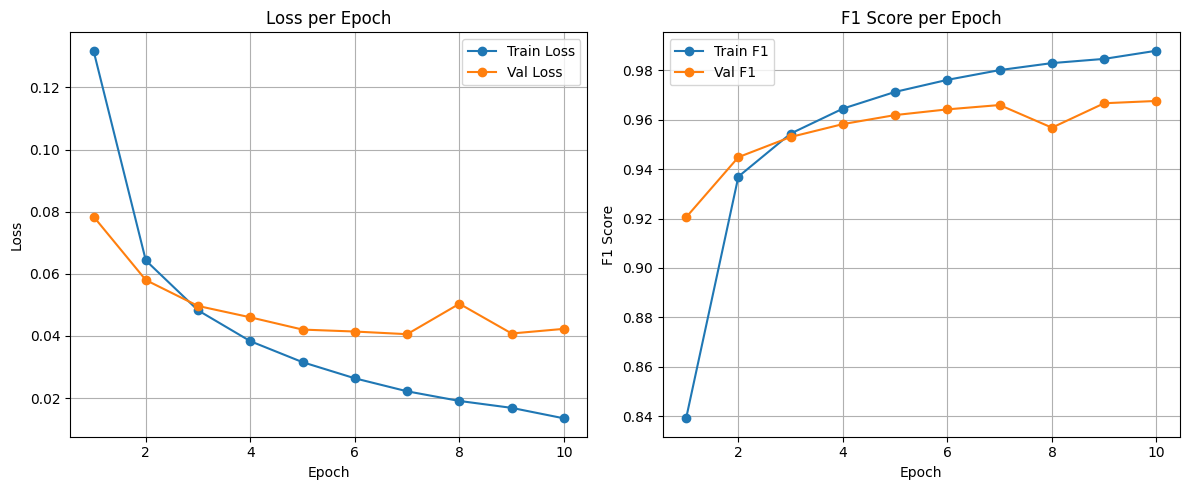

In [32]:
# наблюдаем переобучение на 7 эпохе, можно было бы регуляризацию добавить и lr scheduler с early stopping

plot_history(history)

In [34]:
def save_model(model, path, config=None):
    checkpoint = {
        "model_state": model.state_dict(),
        "config": config
    }
    torch.save(checkpoint, path)
    print(f"✅ Модель сохранена в {path}")

In [35]:
# сохранение

config = {
    "vocab_size": vocab_size,
    "hidden_dim": 128,
    "num_layers": 1,
    "embed_dim": 64
}

save_model(model, "/models/bilstm_checkpoint.pth", config)

✅ Модель сохранена в /content/bilstm_checkpoint.pth


# Инференс

Вообще говоря можно добавить дополнитиельные эвристики: после того как модель сделал предсказание дополнять гарантированными пробелами, например: <p>-перед числом ставить пробел <p>-перед "ы" никогда не может быть пробела, так как нет слов на букву ы <p>-ключевые слова, характерные для домена данный (объявления: ищу, куплю и тд)

In [14]:
import pandas as pd
import re
from typing import List, Tuple
import numpy as np
import torch as torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from rich.console import Console
from rich.table import Table
from rich.progress import Progress, BarColumn, TimeRemainingColumn, TimeElapsedColumn
import time
import matplotlib.pyplot as plt

from modeling_utils import *
from preprop_utils import *

In [2]:
def load_model(model_class, path, device):
    checkpoint = torch.load(path, map_location=device)
    config = checkpoint["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"✅ Модель загружена из {path}")
    return model, config

In [4]:
# использую BiLSTM так как по условию главная цель: легковесность (можно было бы взять трансформеры, но они громоздкие)
# можно было бы еще поэкспериментировать с методами регуляризации (DropOut и BatchNorm), но мне не хватает времени :(

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        logits = self.fc(lstm_out)
        return logits


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loaded_model, loaded_cfg = load_model(BiLSTM, "/models/bilstm_checkpoint.pth", device)

✅ Модель загружена из /content/bilstm_checkpoint.pth


In [6]:
device

'cpu'

In [7]:
sum(p.numel() for p in loaded_model.parameters())

208706

In [8]:
loaded_model

BiLSTM(
  (embedding): Embedding(149, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [9]:
def prepare_pipline(path, char2id) -> pd.DataFrame:
    data = file_to_df(path, format='txt')

    data['tokens'] = data['text_no_spaces'].apply(lambda x: tokenize_text(x, char2id))

    return data

In [11]:
import json

with open("/data/char2id.json", "r", encoding="utf-8") as f:
    char2id = json.load(f)

In [15]:
test_data = prepare_pipline('/data/dataset_1937770_3.txt', char2id)

In [47]:
# import json

# with open("/content/char2id.json", "w", encoding="utf-8") as f:
#     json.dump(char2id, f, ensure_ascii=False, indent=2)

In [16]:
test_data

,id,text_no_spaces,tokens
0,0,куплюайфон14про,"[124, 133, 129, 125, 144, 114, 123, 134, 128, ..."
1,1,ищудомвПодмосковье,"[122, 139, 133, 118, 128, 126, 116, 97, 128, 1..."
2,2,сдаюквартирусмебельюитехникой,"[131, 118, 114, 144, 124, 116, 114, 130, 132, ..."
3,3,новыйдивандоставканедорого,"[127, 128, 116, 141, 123, 118, 122, 116, 114, ..."
4,4,отдамдаромкошку,"[128, 132, 118, 114, 126, 118, 114, 130, 128, ..."
...,...,...,...
1000,1000,Янеусну.,"[113, 127, 119, 133, 131, 127, 133, 11]"
1001,1001,Весна-яуженегреюпио.,"[84, 119, 131, 127, 114, 10, 145, 133, 120, 11..."
1002,1002,Весна-скоровырастеттрава.,"[84, 119, 131, 127, 114, 10, 131, 124, 128, 13..."
1003,1003,"Весна-выпосмотрите,каккрасиво.","[84, 119, 131, 127, 114, 10, 116, 141, 129, 12..."


In [17]:
test_data = [torch.tensor(seq, dtype=torch.long) for seq in test_data['tokens']]

In [18]:
pad_value = 0
test_data = pad_sequence(test_data, batch_first=True, padding_value=pad_value)

In [19]:
test_data = test_data.to(device)

In [20]:
loaded_model = loaded_model.to(device)

In [21]:
test_data

tensor([[124, 133, 129,  ...,   0,   0,   0],
        [122, 139, 133,  ...,   0,   0,   0],
        [131, 118, 114,  ...,   0,   0,   0],
        ...,
        [ 84, 119, 131,  ...,   0,   0,   0],
        [ 84, 119, 131,  ...,   0,   0,   0],
        [ 84, 119, 131,  ...,   0,   0,   0]])

In [22]:
mask = (test_data != 0)

In [23]:
logits = loaded_model(test_data)
probs = torch.softmax(logits, dim=-1)
pred_mask = torch.argmax(probs, dim=-1)      # [batch, seq_len]
pred_mask = pred_mask.squeeze(0)

In [24]:
pred_mask.shape

torch.Size([1005, 56])

In [25]:
pred_mask

tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1]])

In [26]:
masked_list = [t[mask[i]] for i, t in enumerate(pred_mask)]

In [27]:
masked_list = [t.tolist() for t in masked_list]

In [ ]:
masked_list

In [29]:
from typing import List

def insert_spaces(text: str, mask: List[int]) -> str:
    """
    Вставить пробелы в текст по маске (1 = начало слова)
    """
    result = []
    for ch, m in zip(text, mask):
        if m == 1 and result:  # если начало слова и это не первый символ
            result.append(" ")
        result.append(ch)
    return "".join(result)

In [32]:
val_data = prepare_pipline('/data/dataset_1937770_3.txt', char2id)

In [33]:
val_data['inds'] = masked_list

In [34]:
val_data['text'] = val_data.apply(lambda row: insert_spaces(row["text_no_spaces"], row["inds"]), axis=1)

In [35]:
val_data['predicted_positions'] = val_data['inds'].apply(lambda arr: [i for i, v in enumerate(arr) if v == 1])

In [36]:
submission = val_data[['id', 'predicted_positions']]

In [37]:
submission

,id,predicted_positions
0,0,"[5, 10, 12]"
1,1,"[1, 6, 7, 10]"
2,2,"[4, 12, 20, 21]"
3,3,"[5, 18, 20]"
4,4,"[5, 10]"
...,...,...
1000,1000,"[1, 3]"
1001,1001,"[5, 6, 7, 10, 12]"
1002,1002,"[5, 6, 11, 15, 19]"
1003,1003,"[5, 6, 8, 19, 22]"


In [ ]:
submission.to_csv('/submissions/submission1.csv')

На СТЕПИКЕ решение дало 86% F1

Позовите на собес пжлста :)

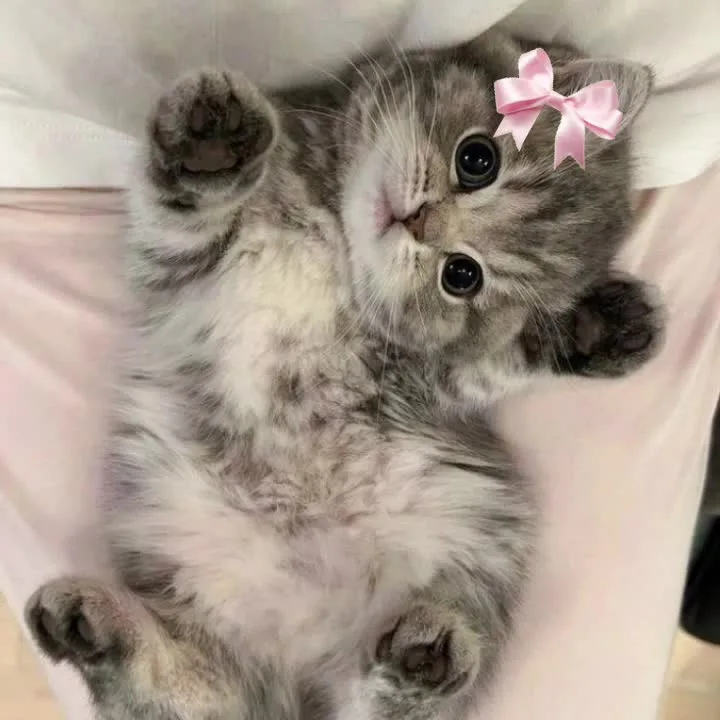